#### This program computes the average ROC curve for a Hough Transform. Still in development...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import math
import random
import cv2
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy import stats 
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import random

In [12]:
sqrt=math.sqrt
pi=math.pi
exp=math.exp
cos=math.cos
sin=math.sin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


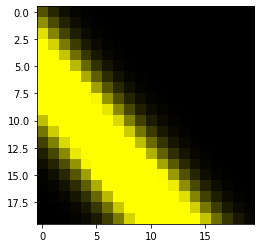

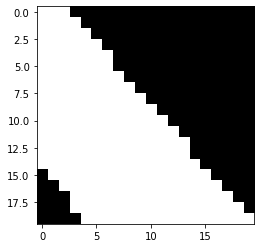

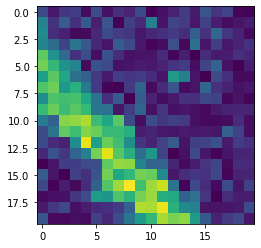

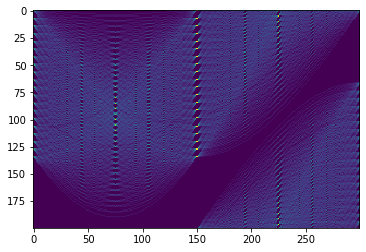

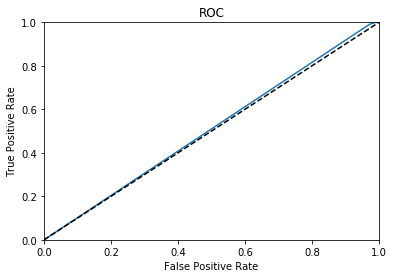

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


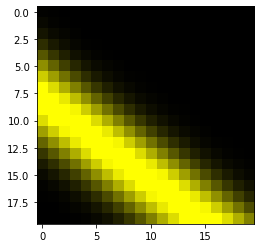

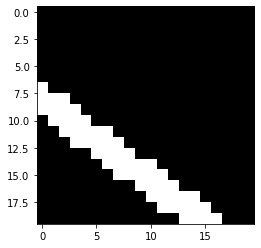

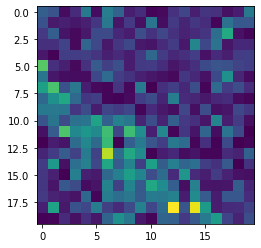

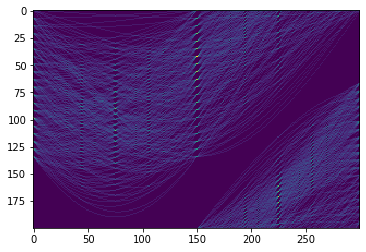

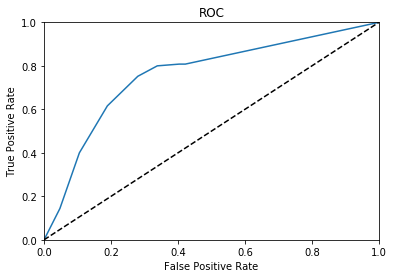

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


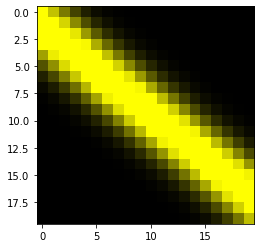

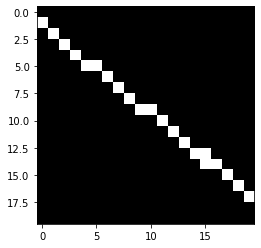

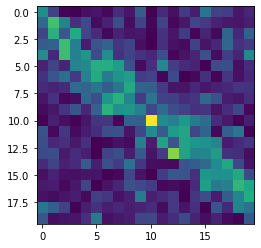

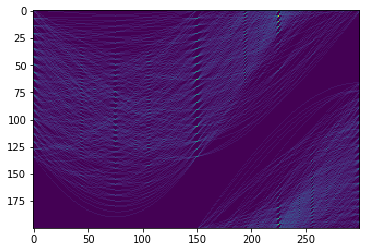

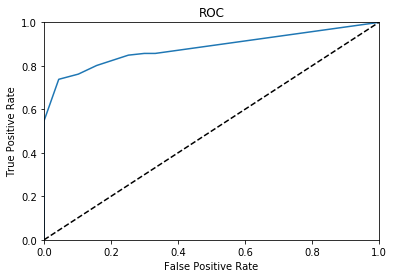

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


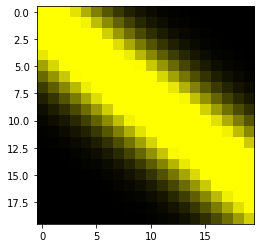

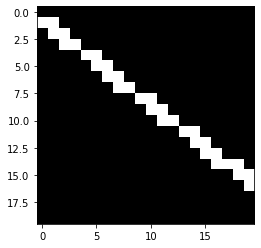

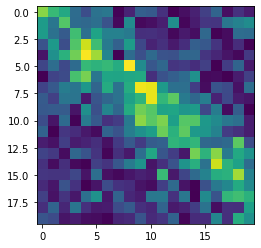

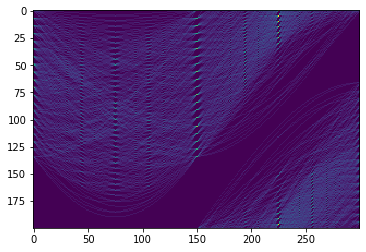

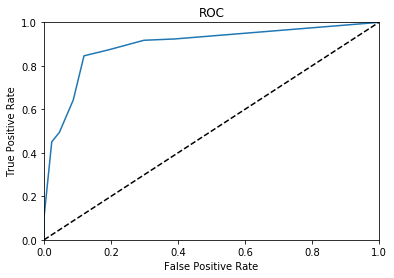

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


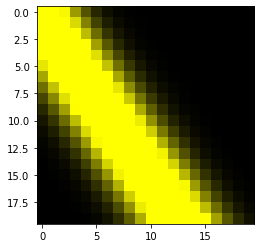

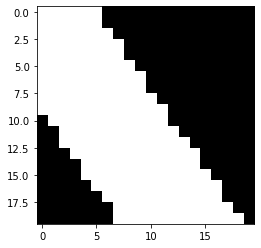

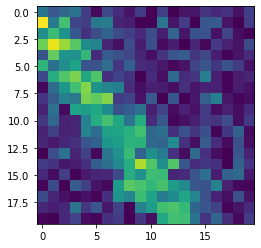

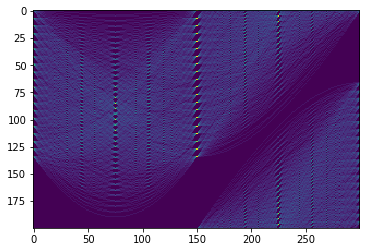

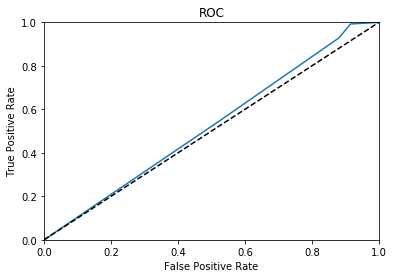

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


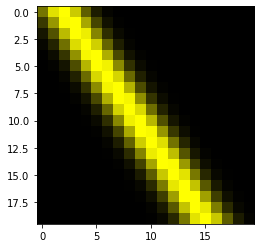

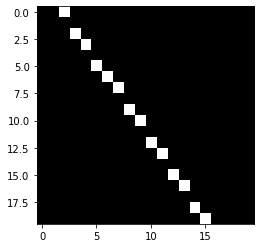

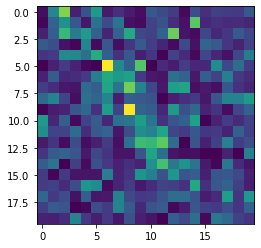

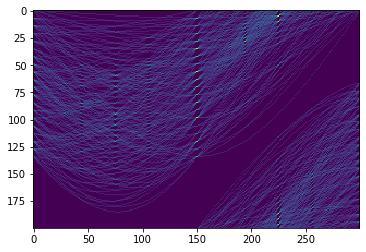

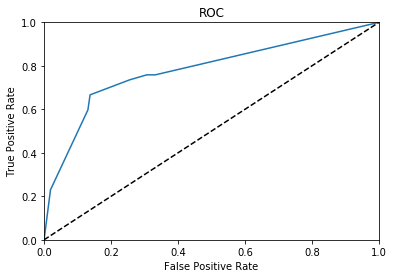

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


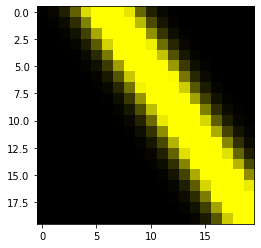

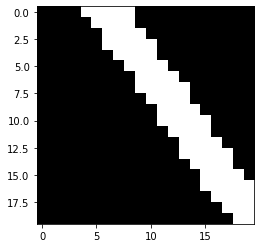

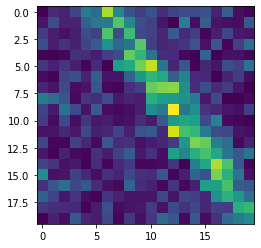

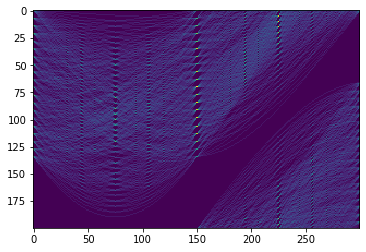

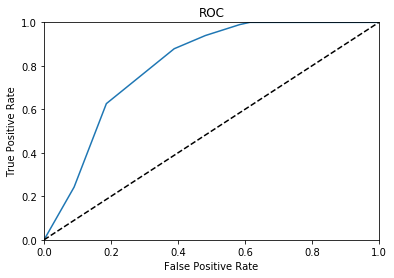

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


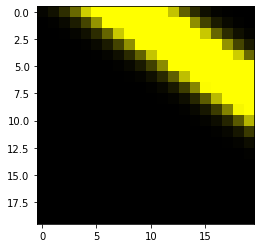

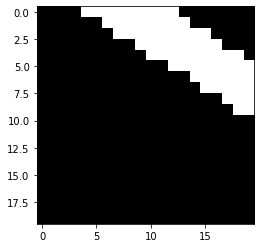

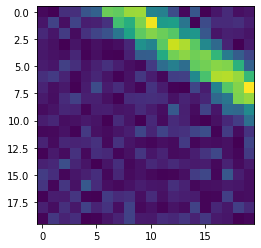

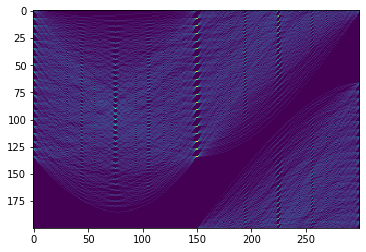

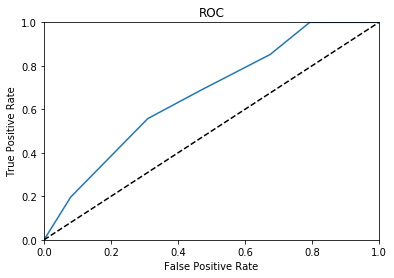

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


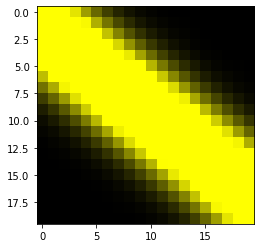

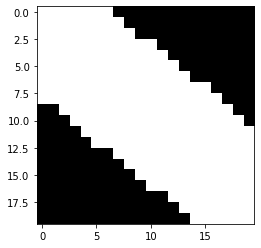

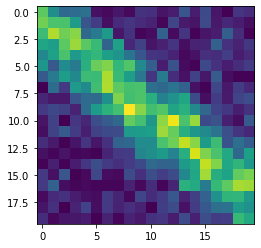

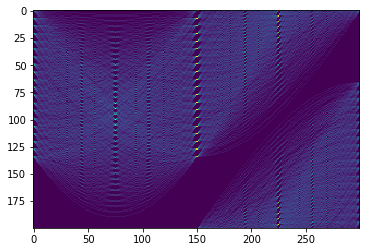

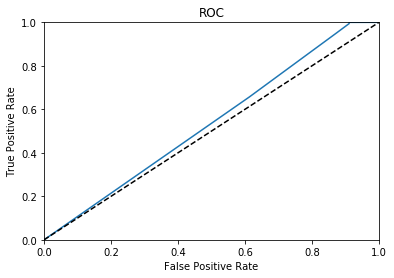

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


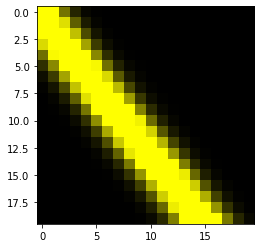

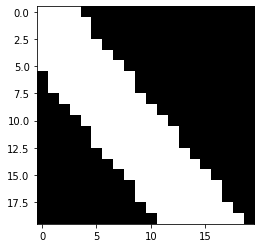

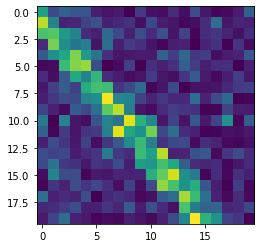

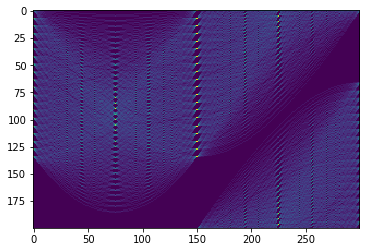

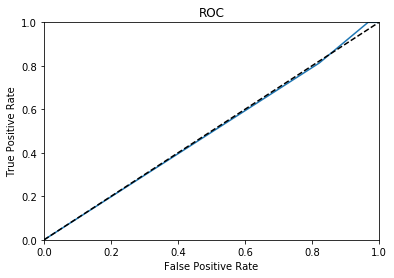

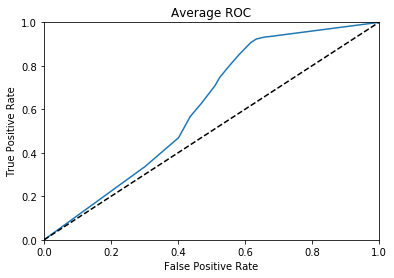

In [42]:
for N in range(10):
    
    alpha=random.uniform(0.523599,1.0472) #The angle made by the generated line(between 30 and 60 degrees)
    sigma=random.uniform(1,3) #determines the width of the track
    ybar=random.uniform(0,10) #determines a y-point through which the track must pass
    xbar=random.uniform(0,10) #determines a x-points through which the track must pass
    SNR=random.uniform(1,3) #determines the SNR ratio
    th=random.uniform(0,1) #determines the threshold
    
    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png")
    pixel=get_image(image,SNR,sigma,alpha,xbar,ybar)#to get the track without any noise
    plt.imshow(pixel)
    plt.show()
    pixel_gray=get_gray(pixel)#to get the grayscale of the track image
    binary_gray=get_binary_gray(pixel_gray,th)#to get the true track pixels
    plt.imshow(binary_gray)
    plt.show()
    pixel_new=get_pixel_new(pixel_gray)#to introduce gaussian noise into the image
    pixel_new_binary=get_pixel_new_binary(pixel_new,th) #binary matrix based on the threshold
    plt.imshow(pixel_new)
    plt.show()
    hough_space,points_x,points_y=get_hough_space(pixel_new_binary)#hough space generator
    plt.imshow(hough_space)
    plt.show()
    
    
    max_points=int(math.hypot(pixel.shape[0],pixel.shape[1]))
    
    if N==0:
        TPR_avg=np.zeros(shape=(max_points))
        FPR_avg=np.zeros(shape=(max_points))
    
    TPR,FPR=get_positive_rates(pixel_gray,hough_space,max_points,points_x,points_y)
    for k in range(max_points):
        TPR_avg[k]=TPR_avg[k]+TPR[k]
        FPR_avg[k]=FPR_avg[k]+FPR[k]
    
    print_ROC(TPR,FPR)
    
for k in range(max_points):
    TPR_avg[k]=TPR_avg[k]/10
    FPR_avg[k]=FPR_avg[k]/10
    
print_ROC_avg(TPR_avg,FPR_avg)

In [2]:
def get_image(image,SNR,sigma,alpha,xbar,ybar):
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            intensity=SNR*exp(-((((j-ybar))*cos(alpha))-(((i-xbar))*sin(alpha)))**2/(2*(sigma)**2))
            image[i,j]=(intensity,intensity,0)
    return image

In [3]:
def get_gray(pixel):
    pixel_gray=np.dot(pixel, [1,1,1])
    return pixel_gray

In [4]:
def get_binary_gray(pixel_gray,th):
    binary_gray=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\test.png");
    
    for i in range(0,pixel_gray.shape[0]):
        for j in range(0,pixel_gray.shape[1]):
            if(pixel_gray[i,j]<(th*np.max(pixel_gray))):
                binary_gray[i,j]=(0,0,0)
    return binary_gray

In [5]:
def get_pixel_new(pixel_gray):
    noise=np.random.normal(0,1,(pixel_gray.shape[0],pixel_gray.shape[1]))               
    pixel_new = np.abs(sqrt(SNR)*pixel_gray + noise)
    return pixel_new

In [6]:
def get_pixel_new_binary(pixel_new,th):
    pixel_new_binary=np.zeros(shape=(pixel_new.shape[0],pixel_new.shape[1]))
    for i in range(0,pixel_new.shape[0]):
        for j in range(0,pixel_new.shape[1]):
            if (pixel_new[i,j]>th):
                pixel_new_binary[i,j]=1
    return pixel_new_binary

In [7]:
def get_hough_space(pixel_new_binary):

    x_max = pixel_new.shape[0]
    y_max = pixel_new.shape[1]

    theta_max = 1.0 *pi 
    theta_min = 0.0

    r_min = 0.0
    r_max = math.hypot(x_max, y_max)

    r_dim = 200 
    theta_dim = 300

    count_coord=100
    points_x=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    points_y=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
   # count=np.zeros(shape=(r_dim,theta_dim),dtype='int')

    hough_space = np.zeros(shape=(r_dim,theta_dim),dtype='int')

    for x in range(x_max):
        for y in range(y_max):
            if pixel_new_binary[x,y] == 0: continue
            for itheta in range(theta_dim):
                
                theta =1.0 *itheta * theta_max / theta_dim
                r = x * cos(theta) + y * sin(theta)
                ir = int(r_dim * ( 1.0 * r ) / r_max)       
                points_x[ir,itheta,hough_space[ir,itheta]]=x
                points_y[ir,itheta,hough_space[ir,itheta]]=y            
                hough_space[ir,itheta] = hough_space[ir,itheta] + 1
            
    return hough_space,points_x,points_y             

In [36]:
def get_positive_rates(pixel_gray,hough_space,max_points,points_x,points_y):
    TPR=np.zeros(shape=(max_points))
    FPR=np.zeros(shape=(max_points))
    
    y_true=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(0,pixel_gray.shape[0]):
        for j in range(0,pixel_gray.shape[1]):
            if(pixel_gray[i,j]>=(np.max(pixel_gray)/3)):
                y_true[i,j]=1
    y_true=y_true.flatten()
            
    r_dim = 200 
    theta_dim = 300
    
    for thresh in range(0,max_points):   
        TP=0
        FP=0
        TN=0
        FN=0    
        y_pred=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
        
        if thresh==0:
            for k in range(pixel_gray.shape[0]):
                for l in range(pixel_gray.shape[1]):
                    y_pred[k,l]=1
        else:
            for i in range(hough_space.shape[0]):
                for j in range(hough_space.shape[1]):
                    if (hough_space[i,j]>=thresh):            
                        for l in range(hough_space[i,j]):
                            y_pred[points_x[i,j,l],points_y[i,j,l]]=1
                    
        y_pred=y_pred.flatten()
  
        for k in range(pixel_gray.shape[0]*pixel_gray.shape[1]):
            if(y_true[k]==1 and y_pred[k]==1):
                TP=TP+1
                    
            elif(y_true[k]==1 and y_pred[k]==0):
                FN=FN+1
                        
            elif(y_true[k]==0 and y_pred[k]==0):
                TN=TN+1
               
            elif(y_true[k]==0 and y_pred[k]==1):
                FP=FP+1 
    
        TPR[thresh]=TP/(TP+FN)
        FPR[thresh]=FP/(FP+TN)
        
    return TPR,FPR

In [9]:
def print_ROC(TPR,FPR):
    plt.plot(FPR,TPR)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()

In [10]:
def print_ROC_avg(TPR_avg,FPR_avg):
    plt.plot(FPR_avg,TPR_avg)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC')
    plt.show()

In [31]:
y=np.zeros(shape=(3,4))
y=1
for i in range(3):
    for j in range(4):
        print(y[i,j])

TypeError: 'int' object is not subscriptable